In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch # Deep learning framework
import torch.nn.functional as F
import time, math

# Input data files are available in the "../input/" directory.
import os
INPUTDIR = '../input/wili5'
print(os.listdir(f'{INPUTDIR}'))

#Init random seed to get reproducible results
seed = 1111
random.seed(seed)
np.random.RandomState(seed)
torch.manual_seed(seed)

# Any results you write to the current directory are saved as output.
x_train_full = open(f'{INPUTDIR}/x_train.txt').read().splitlines()
y_train_full = open(f'{INPUTDIR}/y_train.txt').read().splitlines()
print('Example:')
print('LANG =', y_train_full[0])
print('TEXT =', x_train_full[0])

['Scripts.txt', 'x_train.txt', 'x_test.txt', 'y_train.txt', 'labels.csv']
Example:
LANG = est
TEXT = Klement Gottwaldi surnukeha palsameeriti ning paigutati mausoleumi. Surnukeha oli aga liiga hilja ja oskamatult palsameeritud ning hakkas ilmutama lagunemise tundemärke. 1962. aastal viidi ta surnukeha mausoleumist ära ja kremeeriti. Zlíni linn kandis aastatel 1949–1989 nime Gottwaldov. Ukrainas Harkivi oblastis kandis Zmiivi linn aastatel 1976–1990 nime Gotvald.


In [2]:
class Dictionary(object):
    def __init__(self):
        self.token2idx = {}
        self.idx2token = []

    def add_token(self, token):
        if token not in self.token2idx:
            self.idx2token.append(token)
            self.token2idx[token] = len(self.idx2token) - 1
        return self.token2idx[token]

    def __len__(self):
        return len(self.idx2token)

The **Dictionary** class is used to map tokens (characters, words, subwords) into consecutive integer indexes.  
The index **0** is reserved for padding sequences up to a fixed lenght, and the index **1** for any 'unknown' character

In [3]:
char_vocab = Dictionary()
pad_token = '<pad>' # reserve index 0 for padding
unk_token = '<unk>' # reserve index 1 for unknown token
pad_index = char_vocab.add_token(pad_token)
unk_index = char_vocab.add_token(unk_token)

# join all the training sentences in a single string
# and obtain the list of different characters with set
chars = set(''.join(x_train_full))
for char in sorted(chars):
    char_vocab.add_token(char)
print("Vocabulary:", len(char_vocab), "UTF characters")

lang_vocab = Dictionary()
# use python set to obtain the list of languages without repetitions
languages = set(y_train_full)
for lang in sorted(languages):
    lang_vocab.add_token(lang)
print("Labels:", len(lang_vocab), "languages")

Vocabulary: 10808 UTF characters
Labels: 235 languages


In [4]:
#From token or label to index
print('a ->', char_vocab.token2idx['a'])
print('cat ->', lang_vocab.token2idx['cat'])
print(y_train_full[0], x_train_full[0][:10])
x_train_idx = [np.array([char_vocab.token2idx[c] for c in line]) for line in x_train_full]
y_train_idx = np.array([lang_vocab.token2idx[lang] for lang in y_train_full])
print(y_train_idx[0], x_train_idx[0][:10])

a -> 67
cat -> 28
est Klement Go
52 [45 78 71 79 71 80 86  2 41 81]


Radomly select 15% of the database for validation  
Create lists of (input, target) tuples for training and validation

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_idx, y_train_idx, test_size=0.15, random_state=seed)
train_data = [(x, y) for x, y in zip(x_train, y_train)]
val_data = [(x, y) for x, y in zip(x_val, y_val)]
print(len(train_data), "training samples")
print(len(val_data), "validation samples")

99875 training samples
17625 validation samples


In [6]:
def batch_generator(data, batch_size, token_size):
    """Yield elements from data in chunks with a maximum of batch_size sequences and token_size tokens."""
    minibatch, sequences_so_far, tokens_so_far = [], 0, 0
    for ex in data:
        seq_len = len(ex[0])
        if seq_len > token_size:
            ex = (ex[0][:token_size], ex[1])
            seq_len = token_size
        minibatch.append(ex)
        sequences_so_far += 1
        tokens_so_far += seq_len
        if sequences_so_far == batch_size or tokens_so_far == token_size:
            yield minibatch
            minibatch, sequences_so_far, tokens_so_far = [], 0, 0
        elif sequences_so_far > batch_size or tokens_so_far > token_size:
            yield minibatch[:-1]
            minibatch, sequences_so_far, tokens_so_far = minibatch[-1:], 1, len(minibatch[-1][0])
    if minibatch:
        yield minibatch

In [7]:
def pool_generator(data, batch_size, token_size, shuffle=False):
    """Sort within buckets, then batch, then shuffle batches.
    Partitions data into chunks of size 100*token_size, sorts examples within
    each chunk, then batch these examples and shuffle the batches.
    """
    for p in batch_generator(data, batch_size * 100, token_size * 100):
        p_batch = batch_generator(sorted(p, key=lambda t: len(t[0]), reverse=True), batch_size, token_size)
        p_list = list(p_batch)
        if shuffle:
            for b in random.sample(p_list, len(p_list)):
                yield b
        else:
            for b in p_list:
                yield b

**DNN Model**  
Includes Python comments with the dimension of the input  matrix:  
T = Max number of tokens in a sequence  
B = Number of sequences (batch size)  
E = Embedding dim  
H = Hidden size  
O = Output size (number of languages)

In [8]:
class CharRNNClassifier(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        if bidirectional: # We have hidden states of both directions
            self.h2o = torch.nn.Linear(hidden_size*2, output_size)
        else:
            self.h2o = torch.nn.Linear(hidden_size, output_size)
        
        
    def forward(self, input, input_lengths):
        # T x B
        encoded = self.embed(input)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        output, _ = padded.max(dim=0)
        # B x H
        output = self.h2o(output)
        # B x O
        return output

    
class CharRNNClassifier_ConcatPooling(torch.nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, output_size, model="lstm", num_layers=1, bidirectional=False, pad_idx=0):
        super().__init__()
        self.model = model.lower()
        self.hidden_size = hidden_size
        self.embed = torch.nn.Embedding(input_size, embedding_size, padding_idx=pad_idx)
        if self.model == "gru":
            self.rnn = torch.nn.GRU(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        elif self.model == "lstm":
            self.rnn = torch.nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=bidirectional)
        if bidirectional: # We have hidden states of both directions
            self.h2o = torch.nn.Linear(hidden_size*4, output_size)
        else:
            self.h2o = torch.nn.Linear(hidden_size*2, output_size)
        self.dropout = torch.nn.Dropout(0.2) # Add dropout after the pooling layer
        
        
    def forward(self, input, input_lengths):
        # T x B
        encoded = self.embed(input)
        print(input.shape)
        # T x B x E
        packed = torch.nn.utils.rnn.pack_padded_sequence(encoded, input_lengths)
        # Packed T x B x E
        output, _ = self.rnn(packed)
        # Packed T x B x H
        # Important: you may need to replace '-inf' with the default zero padding for other pooling layers
        max_padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output, padding_value=float('-inf'))
        # T x B x H
        max_pooled, _ = max_padded.max(dim=0)
        avg_padded, _ = torch.nn.utils.rnn.pad_packed_sequence(output)
        avg_pooled = avg_padded.mean(dim=0)
        # Concat avg pooling and max pooling
        pool_concat = torch.cat((max_pooled,avg_pooled),dim=1)
        # Add dropout
        output = self.dropout(pool_concat)
        # B x H
        output = self.h2o(output)
        # B x O
        return output

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -Inf)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
    
class SelfAttention(torch.nn.Module):
    def __init__(self, embed_dim, bias=True):
        super().__init__()
        self.k_proj = torch.nn.Linear(embed_dim, embed_dim, bias=bias)
        self.v_proj = torch.nn.Linear(embed_dim, embed_dim, bias=bias)
        self.q_proj = torch.nn.Linear(embed_dim, embed_dim, bias=bias)
        self.out_proj = torch.nn.Linear(embed_dim, embed_dim, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        # Empirically observed the convergence to be much better with the scaled initialization
        torch.nn.init.xavier_uniform_(self.k_proj.weight, gain=1 / math.sqrt(2))
        torch.nn.init.xavier_uniform_(self.v_proj.weight, gain=1 / math.sqrt(2))
        torch.nn.init.xavier_uniform_(self.q_proj.weight, gain=1 / math.sqrt(2))
        torch.nn.init.xavier_uniform_(self.out_proj.weight)
        if self.out_proj.bias is not None:
            torch.nn.init.constant_(self.out_proj.bias, 0.)

    # B = Batch size
    # W = Number of context words (left + right)
    # E = embedding_dim
    def forward(self, x):
        # x shape is (B, W, E)
        q = self.q_proj(x)
        # q shape is (B, W, E)
        k = self.k_proj(x)
        # k shape is (B, W, E)
        v = self.v_proj(x)
        # k shape is (B, W, E)
        y, _ = attention(q, k, v)
        # y shape is (B, W, E)
        y = self.out_proj(y)
        # y shape is (B, W, E)
        return y

class CosinePositionalEncoding(torch.nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 10000):
        """
        Args:
            d_model (int): Embedding dimensionality
            dropout (float): Dropout probability on the forward pass
            max_len (int): Maximum length of a sequence to expect
        """
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # Don the transpose because the class originally expected shape [seq_len, batch_size, embedding_dim]
        x = torch.transpose(x, 0, 1)
        x = x + self.pe[:x.size(0)]
        return torch.transpose(self.dropout(x), 0 ,1) # Return original size
    
class TransformerLayer(torch.nn.Module):
    def __init__(self, d_model, dim_feedforward=512, dropout=0.1, activation="relu"):
        super().__init__()
        self.self_attn = SelfAttention(d_model)
        # Implementation of Feedforward model
        self.linear1 = torch.nn.Linear(d_model, dim_feedforward)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear2 = torch.nn.Linear(dim_feedforward, d_model)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.self_attn(src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model,n_heads, dim_feedforward=512, dropout=0.1, activation="relu"):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = int(d_model/n_heads)
        self.att_heads = torch.nn.ModuleList([TransformerLayer(self.d_head) for i in range(n_heads)])

    def forward(self, src):
        out = None
        for i,emb_section in enumerate(torch.split(src,self.d_head,dim = 2)):
            #print(emb_section.shape,src.shape)
            out_section = self.att_heads[i](emb_section)
            if out is None:
                out = out_section
            else:
                out = torch.cat((out,out_section),2)
        return out

    
class EncoderLayer(torch.nn.Module):

    def __init__(self, embed_dim, ffn_dim, num_heads, dropout=0.0):
        """
        Args:
            embed_dim (int): Embedding dimensionality (input, output & self-attention)
            ffn_dim (int): Inner dimensionality in the FFN
            num_heads (int): Number of heads of the multi-head attention block
            dropout (float): Dropout probability
        """
        super(EncoderLayer, self).__init__()

        self.att1 = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = torch.nn.Sequential(
            torch.nn.Linear(embed_dim, ffn_dim),
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(ffn_dim, embed_dim)
        )
        self.norm1 = torch.nn.LayerNorm(embed_dim)
        self.norm2 = torch.nn.LayerNorm(embed_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        # Multihead Attention block
        selfattn_out = self.att1(x)

        # Add + normalize block (1)
        x = self.norm1(x + selfattn_out)

        # FFN block
        ffn_out = self.ffn(x)
        ffn_out = self.dropout(ffn_out)

        # Add + normalize block (2)
        x = self.norm2(x + ffn_out)

        return x


class Char_Attention_Classifier(torch.nn.Module):
    """ Reusing the best model from last lab """
    def __init__(self, num_embeddings, embedding_size, output_size, num_layers=6, n_heads=2, ffn_dim= 1024):
        super().__init__()
        # Use Cosine Positional encoding as input sequence can have different lengths.
        self.position_embedding = CosinePositionalEncoding(embedding_size)
        self.emb = torch.nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.lin = torch.nn.Linear(embedding_size, output_size, bias=False)        
        #self.position_embedding = torch.nn.Parameter(torch.Tensor(input_size, embedding_size))
        #torch.nn.init.xavier_uniform_(self.position_embedding)
        self.encoder_layers = torch.nn.ModuleList([
            EncoderLayer(embedding_size, ffn_dim, n_heads, dropout = 0.1)
            for _ in range(num_layers)
        ])

    # B = Batch size
    # W = Number of context words (left + right)
    # E = embedding_dim
    # V = num_embeddings (number of words)
    def forward(self, input, input_lengths):
        x = torch.transpose(input, 0, 1)
        # input shape is (B,W)
        x = self.emb(x)
        # x shape is (B, W, E)
        x = self.position_embedding(x)
        # x shape is (B, W, E)
        for layer in self.encoder_layers:
            x = layer(x)
        # x shape is (B, W, E)
        x = torch.sum(x,dim=1)
        # x shape is (B, E)
        x = self.lin(x)
        # x shape is (B, V)
        return x

In [9]:
if not torch.cuda.is_available():
    print("WARNING: CUDA is not available. Select 'GPU On' on kernel settings")
device = torch.device("cuda")
torch.cuda.manual_seed(seed)

The **nn.CrossEntropyLoss()** criterion combines **nn.LogSoftmax()** and **nn.NLLLoss()** in one single class.  
It is useful when training a classification problem.

In [10]:
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

In [11]:
def train(model, optimizer, data, batch_size, token_size, max_norm=1, log=False):
    model.train()
    total_loss = 0
    ncorrect = 0
    nsentences = 0
    ntokens = 0
    niterations = 0
    for batch in pool_generator(data, batch_size, token_size, shuffle=True):
        # Get input and target sequences from batch
        X = [torch.from_numpy(d[0]) for d in batch]
        X_lengths = [x.numel() for x in X]
        ntokens += sum(X_lengths)
        X_lengths = torch.tensor(X_lengths, dtype=torch.long)
        y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
        # Pad the input sequences to create a matrix
        X = torch.nn.utils.rnn.pad_sequence(X).to(device)
        model.zero_grad()
        output = model(X, X_lengths)
        loss = criterion(output, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)      # Gradient clipping https://www.kaggle.com/c/wili4/discussion/231378
        optimizer.step()
        # Training statistics
        total_loss += loss.item()
        ncorrect += (torch.max(output, 1)[1] == y).sum().item()
        nsentences += y.numel()
        niterations += 1
    
    total_loss = total_loss / nsentences
    accuracy = 100 * ncorrect / nsentences
    if log:
        print(f'Train: wpb={ntokens//niterations}, bsz={nsentences//niterations}, num_updates={niterations}')
    return accuracy

In [12]:
def validate(model, data, batch_size, token_size):
    model.eval()
    # calculate accuracy on validation set
    ncorrect = 0
    nsentences = 0
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input and target sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            y = torch.tensor([d[1] for d in batch], dtype=torch.long, device=device)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            ncorrect += (torch.max(answer, 1)[1] == y).sum().item()
            nsentences += y.numel()
        dev_acc = 100 * ncorrect / nsentences
    return dev_acc

In [13]:
#hidden_size = 256
#embedding_size = 64

ntokens = len(char_vocab)
nlabels = len(lang_vocab)

Model for cross-validation

In [14]:
def get_model(num_model):
    if num_model == 1:
        model = CharRNNClassifier(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index, num_layers = 3).to(device)
    if num_model == 2:
        model = CharRNNClassifier_ConcatPooling(ntokens, embedding_size, hidden_size, nlabels, bidirectional=bidirectional, pad_idx=pad_index, num_layers = 3).to(device)
    if num_model == 3:
        model = Char_Attention_Classifier(ntokens, embedding_size, nlabels, num_layers = 3, n_heads=2).to(device)
    optimizer = torch.optim.Adam(model.parameters())
    return model, optimizer

In [15]:
batch_size = 128
token_size = 10000
#hidden_size = 512//2
embedding_size = 64
#bidirectional = True
#hidden_size = 512

epochs = 25
train_accuracy = []
valid_accuracy = []
model, optimizer = get_model(3)
print(f'Training cross-validation model for {epochs} epochs')
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data, batch_size, token_size, log=epoch==1)
    train_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.1f}% ({time.time() - t0:.0f}s)')
    acc = validate(model, val_data, batch_size, token_size)
    valid_accuracy.append(acc)
    print(f'| epoch {epoch:03d} | valid accuracy={acc:.1f}%')

Training cross-validation model for 25 epochs
Train: wpb=9646, bsz=26, num_updates=3793
| epoch 001 | train accuracy=36.2% (220s)
| epoch 001 | valid accuracy=73.0%
| epoch 002 | train accuracy=77.3% (446s)
| epoch 002 | valid accuracy=81.2%
| epoch 003 | train accuracy=82.5% (670s)
| epoch 003 | valid accuracy=82.6%
| epoch 004 | train accuracy=84.3% (893s)
| epoch 004 | valid accuracy=83.9%
| epoch 005 | train accuracy=85.5% (1115s)
| epoch 005 | valid accuracy=84.3%
| epoch 006 | train accuracy=86.1% (1338s)
| epoch 006 | valid accuracy=86.1%
| epoch 007 | train accuracy=86.7% (1562s)
| epoch 007 | valid accuracy=86.0%
| epoch 008 | train accuracy=87.2% (1785s)
| epoch 008 | valid accuracy=86.2%
| epoch 009 | train accuracy=87.5% (2007s)
| epoch 009 | valid accuracy=86.2%
| epoch 010 | train accuracy=87.8% (2230s)
| epoch 010 | valid accuracy=87.1%
| epoch 011 | train accuracy=88.0% (2453s)
| epoch 011 | valid accuracy=86.3%
| epoch 012 | train accuracy=88.1% (2675s)
| epoch 012 | v

In [16]:
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

Char_Attention_Classifier(
  (position_embedding): CosinePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (emb): Embedding(10808, 64, padding_idx=0)
  (lin): Linear(in_features=64, out_features=235, bias=False)
  (encoder_layers): ModuleList(
    (0): EncoderLayer(
      (att1): MultiHeadAttention(
        (att_heads): ModuleList(
          (0): TransformerLayer(
            (self_attn): SelfAttention(
              (k_proj): Linear(in_features=32, out_features=32, bias=True)
              (v_proj): Linear(in_features=32, out_features=32, bias=True)
              (q_proj): Linear(in_features=32, out_features=32, bias=True)
              (out_proj): Linear(in_features=32, out_features=32, bias=True)
            )
            (linear1): Linear(in_features=32, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=512, out_features=32, bias=True)
            (norm1): LayerNorm((32,), eps=1e-05, elem

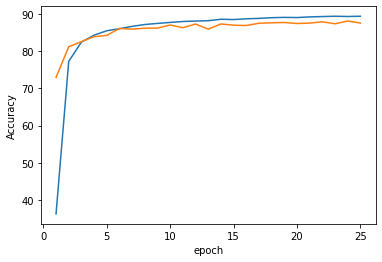

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_accuracy)+1), train_accuracy)
plt.plot(range(1, len(valid_accuracy)+1), valid_accuracy)
plt.xlabel('epoch')
plt.ylabel('Accuracy');

import matplotlib.pyplot as plt
plt.plot([64, 128, 256], [99.7, 99.2, 98.9])
plt.plot([64, 128, 256], [93.7, 93.8, 93.5])
plt.legend(["Training accuracy", "Testing accuracy"])
plt.title("Accuracies for different embedding sizes")
plt.xticks([64, 128, 256])
plt.xlabel('Embedding size')
plt.ylabel('Accuracy');

**Final model**  
Finally, we create a model using all the training data and we generate the submission with the predicted test labels

In [18]:
print(f'Training final model for {epochs} epochs')
model, optimizer = get_model(3)
t0 = time.time()
for epoch in range(1, epochs + 1):
    acc = train(model, optimizer, train_data + val_data, batch_size, token_size, log=epoch==1)
    print(f'| epoch {epoch:03d} | train accuracy={acc:.3f} ({time.time() - t0:.0f}s)')

Training final model for 25 epochs
Train: wpb=9645, bsz=26, num_updates=4466
| epoch 001 | train accuracy=38.635 (253s)
| epoch 002 | train accuracy=77.788 (506s)
| epoch 003 | train accuracy=82.453 (759s)
| epoch 004 | train accuracy=84.313 (1012s)
| epoch 005 | train accuracy=85.419 (1265s)
| epoch 006 | train accuracy=86.268 (1518s)
| epoch 007 | train accuracy=86.705 (1770s)
| epoch 008 | train accuracy=87.205 (2023s)
| epoch 009 | train accuracy=87.590 (2276s)
| epoch 010 | train accuracy=87.715 (2529s)
| epoch 011 | train accuracy=88.066 (2782s)
| epoch 012 | train accuracy=88.139 (3034s)
| epoch 013 | train accuracy=88.428 (3287s)
| epoch 014 | train accuracy=88.557 (3541s)
| epoch 015 | train accuracy=88.689 (3794s)
| epoch 016 | train accuracy=88.809 (4046s)
| epoch 017 | train accuracy=88.797 (4299s)
| epoch 018 | train accuracy=89.066 (4552s)
| epoch 019 | train accuracy=89.220 (4805s)
| epoch 020 | train accuracy=89.220 (5057s)
| epoch 021 | train accuracy=89.331 (5310s)
| 

In [19]:
def test(model, data, batch_size, token_size):
    model.eval()
    sindex = []
    labels = []
    with torch.no_grad():
        for batch in pool_generator(data, batch_size, token_size):
            # Get input sequences from batch
            X = [torch.from_numpy(d[0]) for d in batch]
            X_lengths = torch.tensor([x.numel() for x in X], dtype=torch.long)
            # Pad the input sequences to create a matrix
            X = torch.nn.utils.rnn.pad_sequence(X).to(device)
            answer = model(X, X_lengths)
            label = torch.max(answer, 1)[1].cpu().numpy()
            # Save labels and sentences index
            labels.append(label)
            sindex += [d[1] for d in batch]
    return np.array(sindex), np.concatenate(labels)

In the test database we replace the label (language) with a sentence index.  

In [20]:
x_test_txt = open(f'{INPUTDIR}/x_test.txt').read().splitlines()
x_test_idx = [np.array([char_vocab.token2idx[c] if c in char_vocab.token2idx else unk_index for c in line]) for line in x_test_txt]
test_data = [(x, idx) for idx, x in enumerate(x_test_idx)]

The sentence index is used to rearrange the labels in the original sentence order

In [21]:
index, labels = test(model, test_data, batch_size, token_size)
order = np.argsort(index)
labels = labels[order]

In [22]:
with open('submission.csv', 'w') as f:
    print('Id,Language', file=f)
    for sentence_id, lang_id in enumerate(labels):
        language = lang_vocab.idx2token[lang_id]
        if sentence_id < 10:
            print(f'{sentence_id},{language}')
        print(f'{sentence_id},{language}', file=f)

0,mwl
1,nld
2,ava
3,kan
4,bjn
5,mon
6,glk
7,lez
8,bul
9,nan
